In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from sklearn import linear_model, tree, neighbors, svm, ensemble
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV, RandomizedSearchCV
import math, warnings
warnings.filterwarnings('ignore')

In [91]:
def read(air_hpg):
    if air_hpg=='air':
        df=pd.read_csv("date_info.csv")
        df_reserve=pd.read_csv("air_reserve.csv")
        df_visit=pd.read_csv("air_visit_data.csv")
        df_date=pd.read_csv("date_info.csv")
        df_store_info=pd.read_csv("air_store_info.csv")
        df_reserve=pd.read_csv("air_reserve.csv")
        air = pd.read_csv("air_store_info_with_nearest_active_station.csv")
    else:
        df=pd.read_csv("date_info.csv")
        df_visit=pd.read_csv("air_visit_data.csv")
        df_date=pd.read_csv("date_info.csv")
        df_store_info=pd.read_csv("air_store_info.csv")
        df_reserve=pd.read_csv("air_reserve.csv")
        air = pd.read_csv("air_store_info_with_nearest_active_station.csv")
    return df,df_visit,df_date,df_store_info,df_reserve,air
        

In [92]:
read('air')

(    calendar_date day_of_week  holiday_flg
 0      2016-01-01      Friday            1
 1      2016-01-02    Saturday            1
 2      2016-01-03      Sunday            1
 3      2016-01-04      Monday            0
 4      2016-01-05     Tuesday            0
 ..            ...         ...          ...
 512    2017-05-27    Saturday            0
 513    2017-05-28      Sunday            0
 514    2017-05-29      Monday            0
 515    2017-05-30     Tuesday            0
 516    2017-05-31   Wednesday            0
 
 [517 rows x 3 columns],                 air_store_id  visit_date  visitors
 0       air_ba937bf13d40fb24  2016-01-13        25
 1       air_ba937bf13d40fb24  2016-01-14        32
 2       air_ba937bf13d40fb24  2016-01-15        29
 3       air_ba937bf13d40fb24  2016-01-16        22
 4       air_ba937bf13d40fb24  2016-01-18         6
 ...                      ...         ...       ...
 252103  air_24e8414b9b07decb  2017-04-18         6
 252104  air_24e8414b9b07decb 

In [93]:
def weather(air,df_visit):
    list_station = list(air.station_id.unique())
    df_visit["visit_date"] = pd.to_datetime(df_visit["visit_date"])
    #air["calendar_date"] = pd.to_datetime(air["calendar_date"])
    weather_info = pd.DataFrame()
    for i in list_station: 
        stat =  i + ".csv"   
        df = pd.read_csv(stat)
        df['station'] = i   
        weather_info = weather_info.append(df)   
        weather_info
    weather_info["calendar_date"] = pd.to_datetime(weather_info["calendar_date"])
    #Getting air_store_id and station ids separately
    air_station = air[['air_store_id','station_id']]
    #Joining with visits data
    air_visits = df_visit.merge(air_station,left_on='air_store_id', right_on='air_store_id')
    #Joining with weather data
    df = air_visits.merge(weather_info,left_on=['station_id','visit_date'], right_on=['station','calendar_date'])
    return df

In [94]:
def reserve(df_reserve):
    df_reserve['id']=df_reserve['air_store_id']+'_'+df_reserve['visit_datetime'].map(str)
    df_reserve['id'] = df_reserve['id'].apply(lambda x: x.split(' ')[0])
    df_reserve["visit_datetime"] = pd.to_datetime(df_reserve["visit_datetime"])
    df_reserve['visit_date']=df_reserve['visit_datetime'].dt.normalize()    
    df_reserve_1=df_reserve.groupby(["id"]).sum()["reserve_visitors"]        
    return pd.DataFrame(df_reserve_1)
    

In [95]:
def store_info(df_store_info):
    df_store_info=pd.read_csv("air_store_info.csv")
    data_cat= df_store_info[['air_genre_name']]
    data_cont=df_store_info
    cat_columns = ['air_genre_name'] 
    df_processed = pd.get_dummies(data_cat, prefix_sep="__",columns=cat_columns)
    data = pd.concat([data_cont, df_processed],axis=1)
    data=data.drop(['air_genre_name','air_area_name','latitude','longitude'],axis=1)
    return data

In [96]:
def dow(date_info):
    date_info["calendar_date"] = pd.to_datetime(date_info["calendar_date"])
    date_info['month']=date_info['calendar_date'].dt.month
    data_cat= date_info[['day_of_week','month']]
    data_cont=date_info
    cat_columns = ['day_of_week','month'] 
    df_processed = pd.get_dummies(data_cat, prefix_sep="__",columns=cat_columns)
    data = pd.concat([data_cont, df_processed],axis=1)
    data.drop(['month'],axis=1,inplace=True)
    features=[]
    i=0
    for names in data.columns:
        if i>0:
            features.append(names)
        else:
            i=i+1
    return data

In [97]:
def gen_test_data(df_visit,df_reserve):
    d1 = df_visit['air_store_id'].unique()
    d1=pd.DataFrame(d1)
    d1['joinkey']=1
    df_reserve["visit_datetime"] = pd.to_datetime(df_reserve["visit_datetime"])
    df_reserve['visit_datetime']=df_reserve['visit_datetime'].dt.normalize()
    
    df_visit["visit_date"] = pd.to_datetime(df_visit["visit_date"])
    d2 = df_reserve[df_reserve['visit_datetime']>'2017-04-22']['visit_datetime'].unique()
    d2=pd.DataFrame(d2)
    d2['joinkey']=1
    visit_test=d1.merge(d2,on='joinkey')
    visit_test.rename(columns = {'0_x':'air_store_id','0_y':'visit_date'}, inplace = True)
    visit_test['visitors']=1
    visit_test['train_test']='Test'
    visit_test.drop(['joinkey'],inplace = True,axis=1)
    df_visit["visit_date"] = pd.to_datetime(df_visit["visit_date"])
    df_visit['train_test']='Train'
    df_visit=pd.concat([df_visit,visit_test],ignore_index=True)
    return df_visit

In [98]:
df_reserve=pd.read_csv("air_reserve.csv")
df_visit=pd.read_csv("air_visit_data.csv")

In [99]:
#test_chk.head()

In [100]:
test_chk= gen_test_data(df_visit, df_reserve)
test_chk[test_chk['train_test'] == 'Test']['air_store_id'].nunique()
test_chk[test_chk['train_test'] == 'Test']['visit_date'].nunique()
test_chk[test_chk['train_test'] == 'Test']['visit_date'].max()
# test_chk[test_chk['train_test'] == 'Test']['visit_date'].min()

Timestamp('2017-05-31 00:00:00')

In [101]:
### sid's file

def city_info():
    df = pd.read_csv("air_store_info.csv")

    df['loc_lvl1'] = df['air_area_name'].apply(lambda x:x.split(" ")[0]).apply(lambda x:x.split('-')[0]).apply(lambda x: x.replace('ō','o')).apply(lambda x: x.replace('Ō','O'))
    df['loc_lvl2'] =  df['air_area_name'].apply(lambda x: x.split(' ')[1]).apply(lambda x:x.split('-')[0]).apply(lambda x: x.replace('ō','o')).apply(lambda x: x.replace('Ō','O'))
    df['city_flag'] = df['loc_lvl1'].apply(lambda x: 'NonCity' if x in ['Hyogo','Hokkaido', 'Miyagi'] else 'City')
    df1 = pd.read_csv('air_visit_data.csv')
    df2 = pd.merge(df, df1,on = 'air_store_id')
    temp = df2.groupby(['latitude','longitude']).agg({'air_store_id' : lambda x: x.nunique(), 'visitors' : ['sum']})
    temp = temp.rename(columns={"air_store_id": "tot_neighbours", "visitors": "tot_visitors"})
    temp['mean_visitors'] = df2.groupby(['latitude','longitude']).agg({'visitors': ['mean']})
    temp.reset_index(inplace= True)

    test = pd.merge(df2,temp, on = ['latitude','longitude'])
    test.head()
    #test.shape[0]

    df_vf  = test.rename(columns = {('tot_neighbours', '<lambda>'): 'tot_neighbours',('tot_visitors', 'sum'): 'tot_visitors'
                          ,('mean_visitors', ''): 'mean_visitors'})
    df_vf['visit_date'] = pd.to_datetime(df_vf['visit_date'])
    df_vf = df_vf[['air_store_id','city_flag','tot_neighbours','tot_visitors','mean_visitors']]
    df_vf = df_vf.drop_duplicates()
    
    
    df_store_info= df_vf
    data_cat= df_store_info[['city_flag']]
    data_cont=df_store_info
    cat_columns = ['city_flag'] 
    df_processed = pd.get_dummies(data_cat, prefix_sep="__",columns=cat_columns)
    data = pd.concat([data_cont, df_processed],axis=1)
    data = data.drop('city_flag', axis = 1)
    
    return data

In [102]:
def mean_visitors(n_date_visitors):
    dv_new = n_date_visitors.groupby(['air_store_id','holiday_flg','day_of_week']).agg({'visitors_x' : ['mean']})
    dv_new.columns = ["_".join(x) for x in dv_new.columns.ravel()]
    dv_new.reset_index(inplace= True)
    dv_new = pd.merge(n_date_visitors, dv_new, how='left',on = ['air_store_id','holiday_flg','day_of_week'])
    return dv_new


In [103]:
def f1(file):
    df,df_visit,df_date,df_store_info,df_reserve,air=read(file)
    print(df_visit.shape[0])
    print(df_visit['air_store_id'].nunique())
    df_date["calendar_date"] = pd.to_datetime(df_date["calendar_date"])
    df_reserve["visit_datetime"] = pd.to_datetime(df_reserve["visit_datetime"])
      
    
    df_visit=gen_test_data(df_visit,df_reserve)
    print(df_visit.shape[0])
    
    df_visit['visit_date_str']=df_visit['visit_date']     
    df=weather(air,df_visit)
    print
    #df.head()
    df.dtypes
    df["visit_date"] = pd.to_datetime(df["visit_date"])
    df['Week_Number'] = df["visit_date"].dt.week
    df['Day_Week']=df["visit_date"].dt.dayofweek
    df['Year']=df["visit_date"].dt.year
    df['Year_lag']=df["Year"]-1
    df_2=df[['air_store_id','Week_Number','Day_Week','Year','visitors']]
    
    #Previous year visit
    n_df = pd.merge(df, df_2, how='left', left_on=['air_store_id','Week_Number','Day_Week','Year_lag'], right_on = ['air_store_id','Week_Number','Day_Week','Year'])
    print("n_df", n_df.shape[0])

    n_df=n_df.sort_values(by=['air_store_id','visit_date'])
    #df_reserve=reserve(df_reserve)
    #n_df=n_df.merge(df_reserve,how = 'left',on=['air_store_id','visit_date'])
    print(n_df.shape[0])
    df_store_info=store_info(df_store_info)
    n_df=n_df.merge(df_store_info,on=['air_store_id'])
    print(n_df.shape[0])
    # past one week lag
    for i in range(1,7):
        col_name="prev_"+str(i)    
        n_df[col_name] = n_df['visitors_x'].shift(i).where(n_df['air_store_id'].shift(i) == n_df['air_store_id'])
     
    # joining with date file to get holiday info
    df_date=dow(df_date)
    n_date_df=n_df.merge(df_date,how='left',left_on='visit_date',right_on='calendar_date')
    n_date_df=n_date_df.drop('calendar_date_y',axis=1)
    n_date_df['id']=n_date_df['air_store_id']+'_'+n_date_df['visit_date_str'].map(str)
    n_date_df['id'] = n_date_df['id'].apply(lambda x: x.split(' ')[0])
    
    df_loc_atrr= city_info()
    n_date_df = pd.merge(n_date_df, df_loc_atrr,on=  ['air_store_id'])
    n_date_df=mean_visitors(n_date_df)
    df_res=reserve(df_reserve)
    n_date_df=n_date_df.merge(df_res,how='left',on='id')
    
    return n_date_df
    

In [104]:
df = f1('air')
print(df.shape[0])

252108
829
284439
n_df 284439
284439
284439
284439


In [105]:
len(df[df.reserve_visitors.notnull()])+len(df[df.reserve_visitors.isnull()])
df_with_reserve=reserve
df.reserve_visitors.notnull()

0         False
1         False
2         False
3         False
4         False
          ...  
284434    False
284435    False
284436    False
284437    False
284438    False
Name: reserve_visitors, Length: 284439, dtype: bool

In [106]:
df.columns

Index(['air_store_id', 'visit_date', 'visitors_x', 'train_test',
       'visit_date_str', 'station_id', 'calendar_date_x', 'avg_temperature',
       'high_temperature', 'low_temperature', 'precipitation',
       'hours_sunlight', 'solar_radiation', 'deepest_snowfall',
       'total_snowfall', 'avg_wind_speed', 'avg_vapor_pressure',
       'avg_local_pressure', 'avg_humidity', 'avg_sea_pressure', 'cloud_cover',
       'station', 'Week_Number', 'Day_Week', 'Year_x', 'Year_lag', 'Year_y',
       'visitors_y', 'air_genre_name__Asian', 'air_genre_name__Bar/Cocktail',
       'air_genre_name__Cafe/Sweets', 'air_genre_name__Creative cuisine',
       'air_genre_name__Dining bar', 'air_genre_name__International cuisine',
       'air_genre_name__Italian/French', 'air_genre_name__Izakaya',
       'air_genre_name__Japanese food', 'air_genre_name__Karaoke/Party',
       'air_genre_name__Okonomiyaki/Monja/Teppanyaki', 'air_genre_name__Other',
       'air_genre_name__Western food', 'air_genre_name__Ya

In [107]:
#subsetting required columns
# We will be building 2 models. One with reservation info and the other without
# The below is for with reservation info
df_with_reserve=df[df.reserve_visitors.notnull()]
data=df_with_reserve[['id','air_store_id','visitors_x', 'train_test',         
        'visitors_x_mean','avg_temperature','station_id',
        'tot_neighbours', 'tot_visitors',
       'air_genre_name__Asian', 'air_genre_name__Bar/Cocktail',
       'air_genre_name__Cafe/Sweets', 'air_genre_name__Creative cuisine',
       'air_genre_name__Dining bar', 'air_genre_name__International cuisine',
       'air_genre_name__Italian/French', 'air_genre_name__Izakaya',
       'air_genre_name__Japanese food', 'air_genre_name__Karaoke/Party',
       'air_genre_name__Okonomiyaki/Monja/Teppanyaki', 'air_genre_name__Other',
       'air_genre_name__Western food', 'air_genre_name__Yakiniku/Korean food',       
       'holiday_flg', 'day_of_week__Friday', 'day_of_week__Monday',
       'day_of_week__Saturday', 'day_of_week__Sunday', 'day_of_week__Thursday',
       'day_of_week__Tuesday', 'day_of_week__Wednesday','city_flag__City' ,'city_flag__NonCity','month__1',
       'month__2', 'month__3', 'month__4', 'month__5', 'month__6', 'month__7',
       'month__8', 'month__9', 'month__10', 'month__11', 'month__12','reserve_visitors']]



In [108]:
data.loc[df.station_id == 'tokyo__setagaya-kana__setagaya', 'avg_temperature'] = "22.2"
data.loc[df.station_id == 'hyogo__nishinomiya-kana__nishinomiya', 'avg_temperature'] = "14.7"
data.loc[df.station_id == 'kanagawa__hiyoshi-kana__hiyoshi', 'avg_temperature'] = "22.2"
data.loc[df.station_id == 'kanagawa__hiyoshi-kana__hiyoshi', 'avg_temperature'] = "13.8"

In [109]:
data["avg_temperature"] = data.avg_temperature.astype(float)

In [110]:
data.shape

(29195, 46)

In [111]:
# identify columns with na
data.loc[:, data.isna().any()]

,avg_temperature
96,14.3
125,12.7
133,8.1
136,6.7
138,9.6
...,...
283198,16.3
283201,16.3
283204,16.0
283226,21.3


In [112]:
data_train=data[data['train_test']=='Train']

data_test=data[data['train_test']=='Test'] # final test dataset for Kaggle

In [113]:
data_train.columns

Index(['id', 'air_store_id', 'visitors_x', 'train_test', 'visitors_x_mean',
       'avg_temperature', 'station_id', 'tot_neighbours', 'tot_visitors',
       'air_genre_name__Asian', 'air_genre_name__Bar/Cocktail',
       'air_genre_name__Cafe/Sweets', 'air_genre_name__Creative cuisine',
       'air_genre_name__Dining bar', 'air_genre_name__International cuisine',
       'air_genre_name__Italian/French', 'air_genre_name__Izakaya',
       'air_genre_name__Japanese food', 'air_genre_name__Karaoke/Party',
       'air_genre_name__Okonomiyaki/Monja/Teppanyaki', 'air_genre_name__Other',
       'air_genre_name__Western food', 'air_genre_name__Yakiniku/Korean food',
       'holiday_flg', 'day_of_week__Friday', 'day_of_week__Monday',
       'day_of_week__Saturday', 'day_of_week__Sunday', 'day_of_week__Thursday',
       'day_of_week__Tuesday', 'day_of_week__Wednesday', 'city_flag__City',
       'city_flag__NonCity', 'month__1', 'month__2', 'month__3', 'month__4',
       'month__5', 'month__6', 'm

In [114]:
train_data, test_data = train_test_split(data_train,test_size=0.20,random_state=120)

features=['visitors_x_mean', 'tot_neighbours', 'tot_visitors', 'avg_temperature','reserve_visitors',
       'air_genre_name__Asian', 'air_genre_name__Bar/Cocktail',
       'air_genre_name__Cafe/Sweets', 'air_genre_name__Creative cuisine',
       'air_genre_name__Dining bar', 'air_genre_name__International cuisine',
       'air_genre_name__Italian/French', 'air_genre_name__Izakaya',
       'air_genre_name__Japanese food', 'air_genre_name__Karaoke/Party',
       'air_genre_name__Okonomiyaki/Monja/Teppanyaki', 'air_genre_name__Other',
       'air_genre_name__Western food', 'air_genre_name__Yakiniku/Korean food',       
       'holiday_flg', 'day_of_week__Friday', 'day_of_week__Monday',
       'day_of_week__Saturday', 'day_of_week__Sunday', 'day_of_week__Thursday',
       'day_of_week__Tuesday', 'day_of_week__Wednesday','city_flag__City' ,'city_flag__NonCity','month__1',
       'month__2', 'month__3', 'month__4', 'month__5', 'month__6', 'month__7',
       'month__8', 'month__9', 'month__10', 'month__11', 'month__12']

train_data_x=train_data[features]
train_data_y=train_data['visitors_x']

test_data_x=test_data[features]
test_data_y=test_data['visitors_x']



In [115]:
xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=56, max_depth=7)
xgb_model.fit(train_data_x, train_data_y)
y_pred = xgb_model.predict(test_data_x)
#rmsle=np.sqrt(mean_squared_log_error( test_data_y, abs(y_pred)))
#print(rmsle)
qc=test_data
qc['Actual']=test_data_y
qc['Predicted']=y_pred 
df_prediction=qc[['Actual','Predicted']]

[23:10:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [116]:
# Compare predictions to actual
qc[qc['holiday_flg']==1][['id','Actual','Predicted','holiday_flg', 'day_of_week__Friday', 'day_of_week__Monday',
       'day_of_week__Saturday', 'day_of_week__Sunday', 'day_of_week__Thursday','avg_temperature',
       'day_of_week__Tuesday', 'day_of_week__Wednesday']]

,id,Actual,Predicted,holiday_flg,day_of_week__Friday,day_of_week__Monday,day_of_week__Saturday,day_of_week__Sunday,day_of_week__Thursday,avg_temperature,day_of_week__Tuesday,day_of_week__Wednesday
216578,air_c2c8435bdb3516d4_2016-11-03,7,22.884062,1,0,0,0,0,1,0.7,0,0
12086,air_0a74a5408a0b8642_2016-12-23,55,53.993168,1,1,0,0,0,0,-1.4,0,0
47531,air_2fc478dc9f0a6b31_2016-12-29,35,22.164465,1,0,0,0,0,1,-3.6,0,0
243387,air_db4b38ebe7a7ceff_2017-02-11,33,27.442505,1,0,0,1,0,0,3.2,0,0
59175,air_399904bdb7685ca0_2016-11-23,74,39.627907,1,0,0,0,0,0,11.2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
174644,air_9b6af3db40da4ae2_2017-01-09,19,30.112812,1,0,1,0,0,0,5.5,0,0
156055,air_8f273fb9ad2fed6f_2017-01-09,16,22.884935,1,0,1,0,0,0,9.0,0,0
183200,air_a257c9749d8d0ff6_2017-01-02,11,21.843679,1,0,1,0,0,0,-1.6,0,0
49537,air_324f7c39a8410e7c_2016-12-30,25,26.433937,1,1,0,0,0,0,5.2,0,0


In [117]:
data_test['visitors']= xgb_model.predict(data_test[features])
#print(y_pred_test) 
#y_pred_test=y_pred_test.dropna()
submission=data_test[['air_store_id','id','visitors']]


[0.30347538 0.01653941 0.02222499 0.01158053 0.1250701  0.00984387
 0.01438726 0.02932637 0.02273004 0.01529378 0.         0.02021103
 0.02308365 0.01688114 0.03288583 0.01769858 0.01318851 0.01813489
 0.01381324 0.02197932 0.01432827 0.01334853 0.014142   0.01513476
 0.01195193 0.01260503 0.01509413 0.02214143 0.         0.01232655
 0.01388696 0.01333887 0.01389815 0.01417379 0.00983047 0.01186524
 0.         0.         0.00879158 0.01093546 0.02385889]


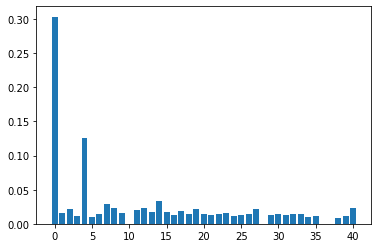

In [118]:
print(xgb_model.feature_importances_)
# plot
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()

In [119]:
# Below is the data for model without reservations
df_without_reserve=df[df.reserve_visitors.isnull()]

data=df_without_reserve[['id','air_store_id','visitors_x', 'train_test',         
        'visitors_x_mean','avg_temperature','station_id',
        'tot_neighbours', 'tot_visitors',
       'air_genre_name__Asian', 'air_genre_name__Bar/Cocktail',
       'air_genre_name__Cafe/Sweets', 'air_genre_name__Creative cuisine',
       'air_genre_name__Dining bar', 'air_genre_name__International cuisine',
       'air_genre_name__Italian/French', 'air_genre_name__Izakaya',
       'air_genre_name__Japanese food', 'air_genre_name__Karaoke/Party',
       'air_genre_name__Okonomiyaki/Monja/Teppanyaki', 'air_genre_name__Other',
       'air_genre_name__Western food', 'air_genre_name__Yakiniku/Korean food',       
       'holiday_flg', 'day_of_week__Friday', 'day_of_week__Monday',
       'day_of_week__Saturday', 'day_of_week__Sunday', 'day_of_week__Thursday',
       'day_of_week__Tuesday', 'day_of_week__Wednesday','city_flag__City' ,'city_flag__NonCity','month__1',
       'month__2', 'month__3', 'month__4', 'month__5', 'month__6', 'month__7',
       'month__8', 'month__9', 'month__10', 'month__11', 'month__12','reserve_visitors']]

data_train=data[data['train_test']=='Train']

data_test=data[data['train_test']=='Test'] # final test dataset for Kaggle

train_data, test_data = train_test_split(data_train,test_size=0.20,random_state=120)

features=['visitors_x_mean', 'tot_neighbours', 'tot_visitors', 'avg_temperature',
       'air_genre_name__Asian', 'air_genre_name__Bar/Cocktail',
       'air_genre_name__Cafe/Sweets', 'air_genre_name__Creative cuisine',
       'air_genre_name__Dining bar', 'air_genre_name__International cuisine',
       'air_genre_name__Italian/French', 'air_genre_name__Izakaya',
       'air_genre_name__Japanese food', 'air_genre_name__Karaoke/Party',
       'air_genre_name__Okonomiyaki/Monja/Teppanyaki', 'air_genre_name__Other',
       'air_genre_name__Western food', 'air_genre_name__Yakiniku/Korean food',       
       'holiday_flg', 'day_of_week__Friday', 'day_of_week__Monday',
       'day_of_week__Saturday', 'day_of_week__Sunday', 'day_of_week__Thursday',
       'day_of_week__Tuesday', 'day_of_week__Wednesday','city_flag__City' ,'city_flag__NonCity','month__1',
       'month__2', 'month__3', 'month__4', 'month__5', 'month__6', 'month__7',
       'month__8', 'month__9', 'month__10', 'month__11', 'month__12']

train_data_x=train_data[features]
train_data_y=train_data['visitors_x']

test_data_x=test_data[features]
test_data_y=test_data['visitors_x']

xgb_model = xgb.XGBRegressor(objective="reg:linear", random_state=56, max_depth=7)
xgb_model.fit(train_data_x, train_data_y)
y_pred = xgb_model.predict(test_data_x)
#rmsle=np.sqrt(mean_squared_log_error( test_data_y, abs(y_pred)))
print(rmsle)
qc=test_data
qc['Actual']=test_data_y
qc['Predicted']=y_pred 
df_prediction_1=qc[['Actual','Predicted']]



[23:10:31] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.5109050605006903


In [120]:
data_test['visitors']= xgb_model.predict(data_test[features])
#print(y_pred_test) 
#y_pred_test=y_pred_test.dropna()
submission_1=data_test[['air_store_id','id','visitors']]

In [121]:
#Concatinating the predictions from the 2 models
df_conc=pd.concat([df_prediction,df_prediction_1])
df_conc

,Actual,Predicted
216578,7,22.884062
245337,26,32.044250
15097,37,18.449043
67207,19,10.813367
69137,42,32.552883
...,...,...
87104,14,15.505028
127095,16,10.993061
243409,11,15.303567
165568,15,25.962629


In [122]:
#Concatinating the submission files from 2 models
submission_conc=pd.concat([submission,submission_1])
len(submission_conc)



32331

In [123]:
#Excluding the unwanted airids
exclude_id=['air_d63cfa6d6ab78446',
'air_b2d8bc9c88b85f96',
'air_0ead98dd07e7a82a',
'air_cb083b4789a8d3a2',
'air_cf22e368c1a71d53',
'air_d0a7bd3339c3d12a',
'air_229d7e508d9f1b5e',
'air_2703dcb33192b181']


submission_final=submission_conc.loc[~submission_conc['air_store_id'].isin(exclude_id)][['id','visitors']]
len(submission_final)
submission_final.to_csv('submission_con.csv')

In [124]:
#Verifying the lenth of final data
len(submission_final)

32019

[0.5002568  0.01381438 0.02405561 0.01931776 0.01602217 0.0343211
 0.0121514  0.01009681 0.00853405 0.00284371 0.01036069 0.00875674
 0.00845046 0.01398915 0.02010383 0.01629192 0.01540753 0.00681499
 0.01237876 0.00837261 0.0184944  0.01259797 0.00993829 0.00716686
 0.01081485 0.0208448  0.00865969 0.         0.01403939 0.01046417
 0.01614527 0.02231443 0.01414559 0.00785098 0.00751881 0.0147243
 0.01005325 0.00796994 0.00982288 0.01409369]


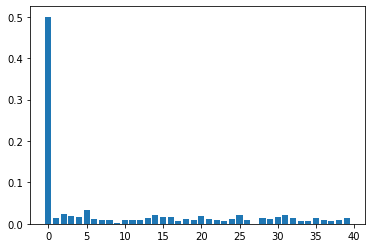

In [125]:
print(xgb_model.feature_importances_)
# plot
plt.bar(range(len(xgb_model.feature_importances_)), xgb_model.feature_importances_)
plt.show()